In [1]:
from collections import defaultdict, Counter
import elotl.corpus
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import statsmodels.api as sm
import os
from re import sub

In [53]:
os.path.join("","")

''

In [63]:
def getCuentos():
    cuentosEsp = []
    cuentosNah = []
    folder = "corpusCuentos"
    files = [os.path.join(folder,val) for val in os.listdir(folder) if os.path.isfile(os.path.join(folder,val))]
    for file in files:
        f = open(file,"r")
        l = f.read().split("\n")
        if file.split(os.path.sep)[1][0:3]=="esp":
            cuentosEsp.append([x for x in l if bool(x)])
        elif file.split(os.path.sep)[1][0:3]=="nah":
            cuentosNah.append([x for x in l if bool(x)])
        f.close()
    return cuentosEsp, cuentosNah

In [64]:
def getSentences(cuentos):
    f = []
    for cuento in cuentos:
        c = []
        for par in cuento:
            sentences = par.split(".")
            sentences = [sub(r"[^\w\s]", " ",sen) for sen in sentences if bool(sen)]
            c.extend(sentences)
        f.append(c)
    return f

In [65]:
cuentosEsp, cuentosNah = getCuentos()

In [70]:
cuentosEsp, cuentosNah = getSentences(cuentosEsp), getSentences(cuentosNah)

In [76]:
oracionesEsp = [item.split(" ") for l in cuentosEsp for item in l]
oracionesNah = [item.split(" ") for l in cuentosNah for item in l]

In [77]:
def buildConcurrencyNetwork(sentencesList,name=""):
    words = [item for lis in sentencesList for item in lis]
    concDG = nx.DiGraph()
    concDG.add_nodes_from(set(words))
    for sentence in sentencesList:
        concDG.add_edges_from(zip(sentence[:-1],sentence[1:]))
    if name:
        nx.readwrite.graphml.write_graphml(concDG,os.path.join("networks","{0}.graphml".format(name)))
    return concDG

In [103]:
G1 = buildConcurrencyNetwork(oracionesEsp) 
G1.remove_node("")

In [104]:
G2 = buildConcurrencyNetwork(oracionesNah) 
G2.remove_node("")

In [105]:
def makeLogLogFit(xs,ys):
    indexes = [i for i in range(len(xs)) if (xs[i]>0 and ys[i]>0)]
    xs = [xs[i] for i in indexes]
    ys = [ys[i] for i in indexes]
    xsfit = sm.add_constant(np.log(xs))
    # build model and train
    mod = sm.OLS(exog=xsfit,endog=np.log(ys))
    fit = mod.fit()
    # make list of predicted data
    ysfit = [np.exp(y) for y in fit.predict(xsfit)]
    # plotting results
    return fit, ysfit

In [106]:
def plotLogLogFit(xs,ysfit,fit,textbox=False,r1=4):
    plt.plot(xs,ysfit,label="Power law fit")
    textstr = "y = {0} x^({1}) \n R^2 = {2}".format(round(np.exp(fit.params[0]),r1),round(fit.params[1],r1),round(fit.rsquared,8))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.95,0.95, textstr,transform=plt.gca().transAxes,  fontsize=14,va='top',ha="right", bbox=props)

In [107]:
def plotLogLog(xs,ys,title,fit=True,norm=True):
    if norm:
        s = sum(ys)
        ys = [y/s for y in ys]
        plt.ylabel("Normalized Frecuency")
    else:
        plt.ylabel("Frecuency")
    plt.plot(xs,ys,label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.title(title)
    plt.grid()
    if fit:
        fit, ysfit = makeLogLogFit(xs,ys)
        # plotting results
        plotLogLogFit(xs,ysfit,fit)

In [108]:
def plotDegreeDistributions(G,title,bins=20,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        degreeCounter = Counter(degreeSequence)
        degrees, count = zip(*degreeCounter.items())
        plt.figure()
        plotLogLog(degrees,count,"{1} \n {0} distribution".format(deg.replace("_"," "),title),fit=fit,norm=norm)
        plt.show()

In [109]:
def plotBinnedDegreeDistributions(G,title,bins=20,fit=False,norm=True):
    if type(G) == nx.classes.digraph.DiGraph:
        degs = ["degree","in_degree","out_degree"]
    else:
        degs = ["degree"]
    for deg in degs:
        func = getattr(G,deg)
        degreeSequence = sorted([d for n,d in func()])
        m1 = degreeSequence[0]
        m2 = degreeSequence[-1]
        if m1==0:
            m1=1
        A = np.logspace(np.log10(m1),np.log10(m2),bins)
        plt.figure()
        if norm:
            weights = np.ones_like(degreeSequence) / float(len(degreeSequence))
            B = plt.hist(degreeSequence,bins=A,ec="k",weights=weights)
            plt.ylabel("Normalized frecuency")
        else: 
            B = plt.hist(degreeSequence,bins=A,ec="k")
            plt.ylabel("Frecuency")
        indexes = [i for i in range(len(A)-1) if B[0][i] > 0]
        xs = [(A[i]+A[i+1])/2 for i in indexes]
        ys = [B[0][i] for i in indexes]
        fit, ysfit = makeLogLogFit(xs,ys)
        plotLogLogFit(xs,ysfit,fit)
        plt.xscale("log")
        plt.yscale("log")
        plt.xlabel("Degree")
        
        plt.title("{1} \n {0} binned distribution".format(deg.replace("_"," "),title))
        plt.grid()
        

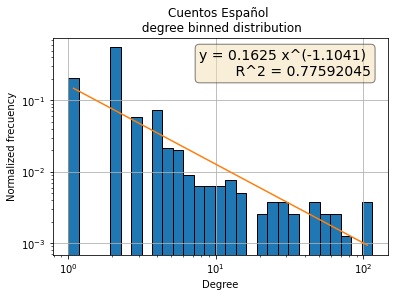

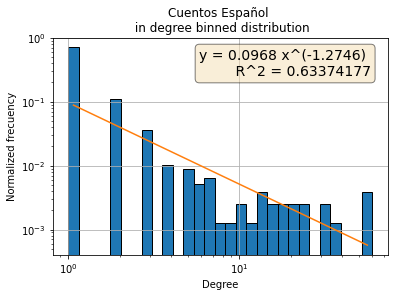

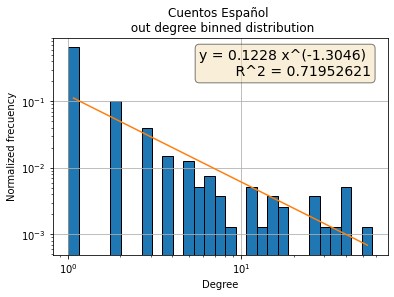

In [113]:
plotBinnedDegreeDistributions(G1,"Cuentos Español",bins=30)

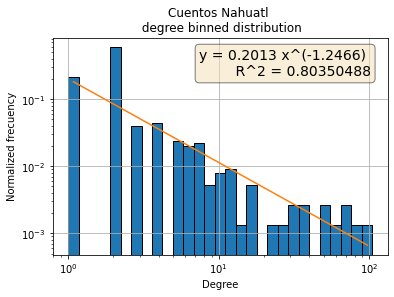

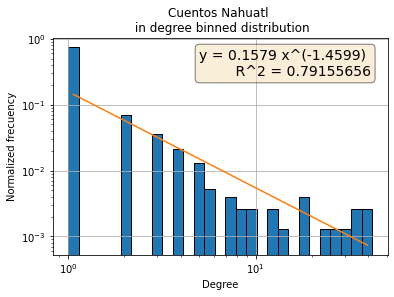

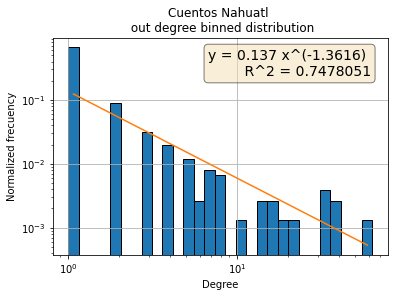

In [114]:
plotBinnedDegreeDistributions(G2,"Cuentos Nahuatl",bins=30)